#### Tracking techniques used by the solver 

In [3]:
def tracker(values):
    stalled = False
    start=0
    answ=[0,0,0,0,0]
    while not stalled:
        initial = transf(values)
        values_before = values.values()
        values = single_position(values)
        values_after = transf(values)
        answ = (answ if values_before == values_after else np.add(answ, [1,0,0,0,0]))
        
        values_before = values_after
        values = single_candidate(values)
        values_after = transf(values)
        answ = (answ if values_before == values_after else np.add(answ, [0,1,0,0,0])) 

        values_before = values_after
        values = naked_twins(values)
        values_after = transf(values)
        answ = (answ if values_before == values_after else np.add(answ, [0,0,1,0,0])) 
        
        values_before = values_after
        values = naked_triple(values)
        values_after = transf(values)
        answ = (answ if values_before == values_after else np.add(answ, [0,0,0,1,0])) 
            
        solved_values = len([box for box in values.keys() if len(values[box]) == 1])
        if solved_values is 81:
            break
 
        stalled = solved_values == 81    
        
        if initial == values_after: 
            start += 1
            aa = [(len(values[s]), s) for s in boxes if len(values[s]) > 1]
            if len(aa) is 0:
                pass
            if len(aa) > 0:
                answ = np.add(answ, [0,0,0,0,1])
                _,s = min(aa)
                for value in values[s]:
                    new_sudoku = values.copy()
                    new_sudoku[s] = value
                    values = new_sudoku
            if start is 10:
                break
    return(answ)

### Making a model to predict the difficulty level of a puzzle

In [1]:
import pandas as pd
import numpy as np
from solver import *
from ai import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pickle

In [2]:
def conv_values(grid):
     return dict(zip(boxes, ["123456789" if element == "." else element for element in grid]))
    
def train_model():
    df = pd.read_csv('../Omega2020/data/dataset.csv').drop('Unnamed: 0', axis=1)
    df = df.drop(df[df.Level == 'TEST'].index)
    df['Tracker'] = df['Sudoku'].apply(lambda x: tracker(conv_values(x)))
    df[['Single', 'Candidate', 'Twins', 'Triples', 'Guess']]=  pd.DataFrame(df['Tracker'].values.tolist(), index= df.index)
    target =['Level']
    features = ['Single','Candidate','Twins','Triples','Guess']
    y = df[target]
    X = df[features]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(solver='lbfgs', multi_class='auto',max_iter=1000)
#Create Pickle
    outfile = open('difficulty_level_model','wb')
    pickle.dump(model.fit(X_train, y_train.values.ravel()),outfile)
    outfile.close()
    return df
df = train_model()

### Testing the model to predict the difficulty level of our test 


In [3]:
test1 = '88..74...1.........7.5.9.4....65.4..73.....296.8.......2.3.1.5.........8...9....2'
test2 = '.5.....7.9......6...21.75.8.4..69.3...8...4...3.42..5.3.12.86...9......1.8.....2.'
test3 = '8...74...1.........7.5.9.4....65.4..73.....296.8.......2.3.1.5.........8...9....2'
test_triple = '...29438....17864.48.3561....48375.1...4157..5..629834953782416126543978.4.961253'
test_triple2='4..5..37.32......4.........8....2.3.21.84...........9..7..9.1..94.651.......7....'
test_triple3='39....7........65.5.7...349.4938.5.66.1.54983853...4..9..8..134..294.8654.....297'
test_rob='...2....58....9..4...18..2.3.....5.95......7..6.....4.........6..1.3498.92.85...3'
rob_example2='...5.47..7.3.....3.....6.2..7..2..639.......543..1..7..5.2...........2.8...9.1...'
names_tests= ['test2','test3','test_triple','test_triple2','test_triple3','test_rob','rob_example2']
tests= [test2,test3,test_triple,test_triple2,test_triple3,test_rob,rob_example2]

count =0
for test in tests:
    values = dict(zip(boxes, ["123456789" if element == "." else element for element in test]))
    print('\n',names_tests[count], solve(test))
    count+=1


 test2 (1, '853946172917582364462137598145869237628375419739421856371298645294653781586714923', '.5.....7.9......6...21.75.8.4..69.3...8...4...3.42..5.3.12.86...9......1.8.....2.', 'Moderate')

 test3 (1, '859174236164832597372569841291657483735418629648293175926381754413725968587946312', '8...74...1.........7.5.9.4....65.4..73.....296.8.......2.3.1.5.........8...9....2', 'Diabolical')

 test_triple (1, '615294387392178645487356129264837591839415762571629834953782416126543978748961253', '...29438....17864.48.3561....48375.1...4157..5..629834953782416126543978.4.961253', 'Diabolical')

 test_triple2 (1, '481526379325917684697384215859762431213849567764135892576293148948651723132478956', '4..5..37.32......4.........8....2.3.21.84...........9..7..9.1..94.651.......7....', 'Diabolical')

 test_triple3 (1, '396425718184739652527168349249381576671254983853697421965872134712943865438516297', '39....7........65.5.7...349.4938.5.66.1.54983853...4..9..8..134..294.8654.....297', 'Moderate')

 te

### Plotting the tracker results with the Dataset

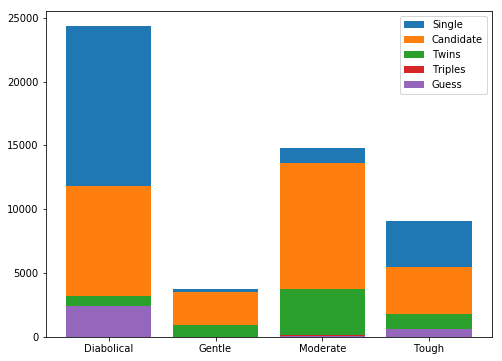

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
df2=df[['Level','Single', 'Candidate', 'Twins','Triples', 'Guess']].groupby('Level').sum().reset_index()
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))
ax.bar(df2['Level'], df2['Single'],label='Single')
ax.bar(df2['Level'], df2['Candidate'] ,label='Candidate')
ax.bar(df2['Level'], df2['Twins'],label='Twins')
ax.bar(df2['Level'], df2['Triples'],label='Triples')
ax.bar(df2['Level'], df2['Guess'],label='Guess')
plt.legend()
plt.show();

#### Analysis:
##### As we can see the most difficulty levels (Diabolical Tough) use 
##### the Guess technique (Search function) to solve a puzzle 

#### Summarizing the results of the tracker

In [8]:
df2=df[['Level','Single', 'Candidate', 'Twins','Triples', 'Guess']].groupby('Level').sum().reset_index()
df2

,Level,Single,Candidate,Twins,Triples,Guess
0,Diabolical,24339,11778,3229,76,2379
1,Gentle,3753,3520,895,23,0
2,Moderate,14772,13609,3719,109,54
3,Tough,9088,5482,1804,52,640


In [9]:
# import matplotlib.pyplot as plt
# import pandas as pd

# fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))
# # ax.bar(df2['Level'], df2['Single'],label='Single')
# ax.bar(df2['Level'], df2['Candidate'] ,label='Candidate')
# ax.bar(df2['Level'], df2['Twins'],label='Twins')
# ax.bar(df2['Level'], df2['Triples'],label='Triples')
# ax.bar(df2['Level'], df2['Guess'],label='Guess')
# plt.legend()
# plt.show();

### Analyzing the what is the range of times that the solver uses a technique to solve a puzzle in each difficulty level

In [11]:
diabolical=df[df['Level']=='Diabolical']
gentle=df[df['Level']=='Gentle']
moderate=df[df['Level']=='Moderate']
tough=df[df['Level']=='Tough']

In [12]:
print('GENTLE:')
print('Guess',np.array(gentle['Guess'].value_counts().index))
print("Triples",np.array(gentle['Triples'].value_counts().index.sort_values()))
print('Twins',np.array(gentle['Twins'].value_counts().index.sort_values()))
print('Candidate',np.array(gentle['Candidate'].value_counts().index.sort_values()))

GENTLE:
Guess [0]
Triples [0 1]
Twins [0 1 2 3 4]
Candidate [ 2  3  4  5  6  7  8 10]


In [13]:
print('Moderate:')
print('Guess',np.array(moderate['Guess'].value_counts().index))
print("Triples",np.array(moderate['Triples'].value_counts().index.sort_values()))
print('Twins',np.array(moderate['Twins'].value_counts().index.sort_values()))
print('Candidate',np.array(moderate['Candidate'].value_counts().index.sort_values()))

Moderate:
Guess [0 1 2 3 5]
Triples [0 1 2]
Twins [0 1 2 3 4 5 6]
Candidate [ 3  4  5  6  7  8  9 10 11 12]


In [14]:
print('Tough:')
print('Guess',np.array(tough['Guess'].value_counts().index))
print("Triples",np.array(tough['Triples'].value_counts().index.sort_values()))
print('Twins',np.array(tough['Twins'].value_counts().index.sort_values()))
print('Candidate',np.array(tough['Candidate'].value_counts().index.sort_values()))

Tough:
Guess [0 1 2 3 4 5 6]
Triples [0 1 2]
Twins [0 1 2 3 4 5 6 7]
Candidate [ 4  5  6  7  8  9 10 11 12 13]


In [15]:
print('Diabolical:')
print('Guess',np.array(diabolical['Guess'].value_counts().index))
print("Triples",np.array(diabolical['Triples'].value_counts().index.sort_values()))
print('Twins',np.array(diabolical['Twins'].value_counts().index.sort_values()))
print('Candidate',np.array(diabolical['Candidate'].value_counts().index.sort_values()))

Diabolical:
Guess [1 2 3 4 0 5 6 7]
Triples [0 1 2]
Twins [0 1 2 3 4 5 6 7 9]
Candidate [ 4  5  6  7  8  9 10 11 12 13 14]


### How did we choose the model to make our predictions?

In [16]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.pipeline import Pipeline

target =['Level']
features = ['Single','Candidate','Twins','Triples','Guess']

y = df[target]
X = df[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
## Make a Pipeline to test all the models 
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    LogisticRegression(solver='lbfgs', multi_class='auto',max_iter=1000),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]
for classifier in classifiers:
    pipe = Pipeline(steps=[
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train.values.ravel())   
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test, y_test.values.ravel()))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')
model score: 0.664


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
model score: 0.703
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
model score: 0.713
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
model score: 0.694
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            ma

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
model score: 0.561
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
model score: 0.720


In [19]:
pipe.predict(X_test)

array(['Moderate', 'Tough', 'Diabolical', ..., 'Diabolical', 'Moderate',
       'Moderate'], dtype=object)

In [20]:
count =0
for test in tests:
    print(names_tests[count], pipe.predict(tracker(conv_values(test)).reshape(1, -1))[0])
    count+=1

test2 Moderate
test3 Diabolical
test_triple Diabolical
test_triple2 Diabolical
test_triple3 Moderate
test_rob Diabolical
rob_example2 Diabolical
